In [1]:
from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile
)

from operator import attrgetter
from datetime import datetime, timedelta

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

fatal: not a git repository (or any of the parent directories): .git


In [3]:
# Parameters

##### release position 
release_zone = "test_1500"
bathymodiolus_delta_lat = 0.6 #seamount diameter

release_depth = 1500

# release particles
number_particles = 10000

# release timing
release_time_in_days = 3   # e.g. from 01/01/2009 to 03/01/2009 
start_year = 2009
start_month = 3
start_day = 1

# experiment duration etc
runtime_in_days = 14
dt_in_minutes = 60

# particle positions are stored every x hours 
outputdt_in_hours = 24

# release location file
release_locations_file = "../data/config/test_stations.csv"

# location of input data
data_path = '/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/'
experiment_name = 'INALT20.L46-KFS119' 
data_resolution = '1d'

# location of mask data
mask_path = data_path
mesh_mask_filename = '1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc'

# names of files to load
fname_U = f'1_{experiment_name}_{data_resolution}_20??*_grid_U_iMirabilis.nc'  
fname_V = f'1_{experiment_name}_{data_resolution}_20??*_grid_V_iMirabilis.nc'
fname_T = f'1_{experiment_name}_{data_resolution}_20??*_grid_T_iMirabilis.nc'
fname_W = f'1_{experiment_name}_{data_resolution}_20??*_grid_W_iMirabilis.nc'

# location of output data
outpath = f'../output_data/{experiment_name}'
output_filename = 'Constant-u-Flow_Line_{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.nc'

# how to initialize the random number generator
RNG_seed = 12345


In [4]:
# remove spaces and lower the input from csv file
release_zone = release_zone.lower().replace(' ', '-').replace("'", '-')

# correct runtime
corrected_runtime_in_days = runtime_in_days + release_time_in_days

### Construct input / output paths etc.

In [5]:
data_path = Path(data_path)
mask_path = Path(mask_path)
outpath = Path(outpath)
mesh_mask = mask_path / experiment_name / mesh_mask_filename
output_filename = output_filename.format(
    release_zone = release_zone,
    RNG_seed=RNG_seed,
    start_year=start_year,
    start_month = start_month,
    start_day = start_day,
    runtime_in_days = runtime_in_days,
    number_particles=number_particles
)
outfile = outpath / output_filename

In [5]:
ds_mesh_mask = xr.open_dataset(mesh_mask)
display(ds_mesh_mask)

<xarray.Dataset>
Dimensions:       (t: 1, y: 409, x: 362, z: 46)
Dimensions without coordinates: t, y, x, z
Data variables: (12/42)
    e1f           (t, y, x) float64 ...
    e1t           (t, y, x) float64 ...
    e1u           (t, y, x) float64 ...
    e1v           (t, y, x) float64 ...
    e2f           (t, y, x) float64 ...
    e2t           (t, y, x) float64 ...
    ...            ...
    tmask         (t, z, y, x) int8 ...
    tmaskutil     (t, y, x) int8 ...
    umask         (t, z, y, x) int8 ...
    umaskutil     (t, y, x) int8 ...
    vmask         (t, z, y, x) int8 ...
    vmaskutil     (t, y, x) int8 ...
Attributes:
    file_name:  1_mesh_mask.nc
    TimeStamp:  01/11/2021 17:36:58 +0100
    NCO:        netCDF Operators version 5.1.2 (Homepage = http://nco.sf.net,...

### Load release location

In [6]:
def load_release_locations(release_locations_file):
    df = pd.read_csv(release_locations_file, delimiter=",")
    df = df.set_index("release_zone")
    df.index = df.index.str.lower().str.replace(' ', '-').str.replace("'", '-')
    return df

In [7]:
release_locations = load_release_locations(release_locations_file)
bathymodiolus_lat, bathymodiolus_lon, release_depth = release_locations.loc[release_zone]
bathymodiolus_delta_lon = bathymodiolus_delta_lat * np.cos(np.deg2rad(bathymodiolus_lat))

In [8]:
def fieldset_defintions(
    list_of_filenames_U, list_of_filenames_V,
    list_of_filenames_W, list_of_filenames_T,
    mesh_mask
):
    
    filenames = {'U': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_U},
                 'V': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_V},
                 'W': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_W},
                 'T': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_T[0],
                       'data': list_of_filenames_T}
                }

    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty',
                 'W': 'vovecrtz',
                 'T': 'votemper'
                }
                 
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                       'time': 'time_counter'}, 
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  
                  'T': {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht',
                        'time': 'time_counter'}, 
                 }  # U,V,W auf f-nodes !  T auf t-nodes

    return FieldSet.from_nemo(
        filenames, variables, dimensions,
        chunksize=False,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer',
        allow_time_extrapolation=True
    )

In [9]:
def create_fieldset(
    data_path=data_path, experiment_name=experiment_name,
    fname_U=fname_U, fname_V=fname_V, fname_W=fname_W, fname_T=fname_T,
    mesh_mask = mesh_mask
):
    
    files_U = list(sorted((Path('../data/config/INALT')).glob('testsetforParcels_u1.nc')))
    files_V = list(sorted((Path('../data/config/INALT')).glob('testsetforParcels_v0.nc')))
    files_W = list(sorted((Path('../data/config/INALT')).glob('testsetforParcels_w0.nc')))
    files_T = list(sorted((data_path / experiment_name).glob('1_INALT20.L46-KFS119_1d_20090101_20091231_grid_T_iMirabilis.nc')))
    
    fieldset = fieldset_defintions(
        files_U, files_V,
        files_W, files_T, mesh_mask)
    return fieldset

In [10]:
list(sorted((data_path / experiment_name).glob(fname_U)))

[PosixPath('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_1d_20080101_20081231_grid_U_iMirabilis.nc'),
 PosixPath('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_1d_20090101_20091231_grid_U_iMirabilis.nc'),
 PosixPath('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_1d_20100101_20101231_grid_U_iMirabilis.nc')]

In [11]:
fieldset = create_fieldset()

### Create a set of particles with random initial positions

In [12]:
np.random.seed(RNG_seed)

time = np.sort(
        datetime(start_year, start_month, start_day)
        + timedelta(hours=1) * np.random.randint(
            0, (release_time_in_days) * 24 * 60 / dt_in_minutes, size=(number_particles, )
        )
)

In [13]:
def get_uniform_random_in_cube(
    lat_start=bathymodiolus_lat-bathymodiolus_delta_lat, lat_end=bathymodiolus_lat+bathymodiolus_delta_lat,
    lon_start=bathymodiolus_lon-bathymodiolus_delta_lon, lon_end=bathymodiolus_lon+bathymodiolus_delta_lon,
    release_depth=release_depth,
    N=10,
):
    lat = np.rad2deg(
        np.arcsin(
            np.random.uniform(
                np.sin(np.deg2rad(lat_start)), 
                np.sin(np.deg2rad(-22.9)),      # eigentlich lat_end statt -22.9
                size=(N, ),
            )
        )
    )
    lon = np.random.uniform(lon_start, lon_end, size=(N, )) 
    depth = np.random.uniform(0,release_depth, size=(N, ))
    
    return pd.DataFrame(
        {
            "lat": lat,
            "lon": lon,
            "depth": depth,
        }
    )

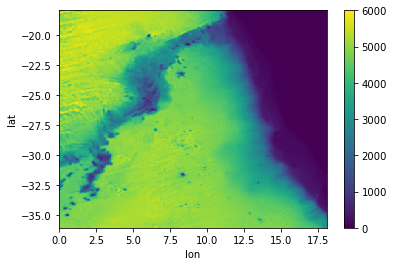

In [14]:
INALT_mask = xr.open_dataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/1_INALT20.L46-KFS119_mesh_mask_iMirabilis.nc')
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT.rename({'lat','lon'})
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0)})
topo_INALT = topo_INALT.assign_coords({"lat": INALT_mask.gphit.isel(t=0,x=0)})
topo_INALT = topo_INALT.swap_dims({'x': 'lon'})
topo_INALT = topo_INALT.swap_dims({'y': 'lat'})

topo_INALT.plot();

In [15]:
release_points = get_uniform_random_in_cube(N=200*number_particles,
)
release_points["topo_INALT"] = topo_INALT.sel(
    lat=release_points.to_xarray().lat,
    lon=release_points.to_xarray().lon,
    method="nearest",
)
release_points = release_points.where((release_points.topo_INALT > release_points.depth+50) & ( # at least 50 meters above ground
    release_points.topo_INALT < release_depth)).dropna().iloc[
    :number_particles].reset_index(drop=True)

In [16]:
def get_uniform_random_in_line(
    release_depth=release_depth,
    N=10,
):
    lat = np.random.uniform(topo_INALT.lat.min(),topo_INALT.lat.max(), size=(N, ))
    lon = np.random.uniform(8.25, 8.25, size=(N, )) 
    depth = np.random.uniform(0,release_depth, size=(N, ))
    
    return pd.DataFrame(
        {
            "lat": lat,
            "lon": lon,
            "depth": depth,
        }
    )

In [17]:
release_points = get_uniform_random_in_line(N=200*number_particles,
)
release_points["topo_INALT"] = topo_INALT.sel(
    lat=release_points.to_xarray().lat,
    lon=release_points.to_xarray().lon,
    method="nearest",
)
release_points = release_points.where((release_points.topo_INALT > release_points.depth+50)).dropna().iloc[
    :number_particles].reset_index(drop=True)

In [18]:
release_points

,lat,lon,depth,topo_INALT
0,-27.768970,8.25,280.766867,5072.987003
1,-31.093145,8.25,1347.781195,4909.982708
2,-29.952617,8.25,233.686909,4987.984952
3,-33.980562,8.25,275.955714,5152.988862
4,-31.159177,8.25,926.278531,4907.982650
...,...,...,...,...
9995,-25.003341,8.25,1497.220582,4700.976341
9996,-32.528921,8.25,141.807088,4957.484074
9997,-19.338077,8.25,864.505634,5001.507247
9998,-27.366928,8.25,615.535665,4946.983772


In [19]:
time[0:3]

array([datetime.datetime(2009, 3, 1, 0, 0),
       datetime.datetime(2009, 3, 1, 0, 0),
       datetime.datetime(2009, 3, 1, 0, 0)], dtype=object)

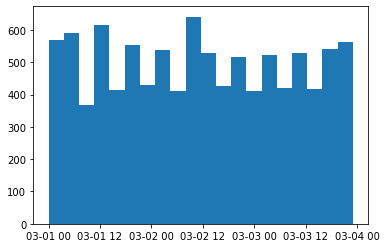

In [20]:
plt.hist(time, bins=20);

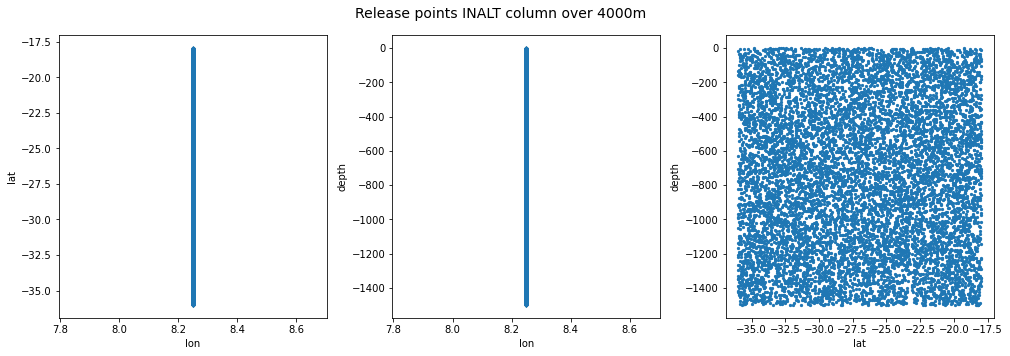

In [21]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
plt.scatter(release_points.lon, release_points.lat, s=5)
plt.xlabel('lon')
plt.ylabel('lat')
plt.subplot(1,3,2)
plt.scatter(release_points.lon, -release_points.depth, s=5)
plt.xlabel('lon')
plt.ylabel('depth')
plt.subplot(1,3,3)
plt.scatter(release_points.lat, -release_points.depth, s=5)
plt.xlabel('lat')
plt.ylabel('depth')

fig.suptitle('Release points INALT column over 4000m',fontsize = 14)
fig.tight_layout()

#plt.savefig(('../output_data/{experiment_name}/plots/release-points_column_{release_zone}_{start_year}{start_month:02d}{start_day:02d}_RT-{runtime_in_days}_N-{number_particles}_seed-{RNG_seed}.png').format(
#    experiment_name = experiment_name,
#    release_zone = release_zone,
#    RNG_seed=RNG_seed,
#    start_year=start_year,
#    start_month = start_month,
#    start_day = start_day,
#    runtime_in_days = runtime_in_days,
#    number_particles=number_particles)
#           )

plt.show;

In [22]:
%%time
pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle, #SampleParticle later? muss dann vorher auch def werden,
    lat=release_points.lat,
    lon=release_points.lon,
    depth=release_points.depth,
    time=time
)

CPU times: user 72.9 ms, sys: 1.12 ms, total: 74 ms
Wall time: 73.3 ms


In [23]:
kernel = pset.Kernel(AdvectionRK4_3D)

### Be able to handle errors during integration

In [24]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
recovery_cases = {ErrorCode.ErrorOutOfBounds: DeleteParticle,
    ErrorCode.ErrorThroughSurface: DeleteParticle
    }

In [6]:
outfile

PosixPath('../output_data/INALT20.L46-KFS119/Constant-u-Flow_Line_test_1500_20090301_RT-14_N-10000_seed-12345.nc')

In [26]:
output_pfile = pset.ParticleFile(name=outfile, outputdt=timedelta(hours=outputdt_in_hours))

In [27]:
pset.execute(
    kernel,
    runtime=timedelta(days=corrected_runtime_in_days),
    dt=timedelta(minutes=dt_in_minutes),
    output_file=output_pfile,
    recovery=recovery_cases,
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-726810/lib0b54d21b3e57186f83435d3c5a08bb93_0.so
INFO: Temporary output files are stored in ../output_data/INALT20.L46-KFS119/out-ECCKKSJZ.
INFO: You can use "parcels_convert_npydir_to_netcdf ../output_data/INALT20.L46-KFS119/out-ECCKKSJZ" to convert these to a NetCDF file during the run.
100%|██████████████████████████| 1468800.0/1468800.0 [00:14<00:00, 98900.45it/s]


In [28]:
output_pfile.export()

In [7]:
particle_ds = xr.open_dataset(outfile)
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 10000, obs: 18)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

NameError: name 'bathymodiolus_lon' is not defined

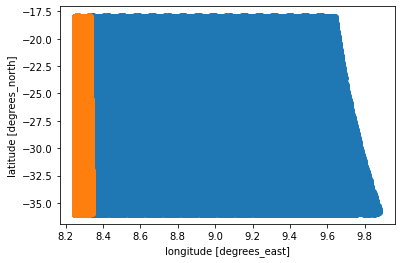

In [8]:
particle_ds.plot.scatter(x="lon", y="lat")
particle_ds.isel(obs=0).plot.scatter(x="lon", y="lat")
plt.plot(bathymodiolus_lon, bathymodiolus_lat, 'rx')

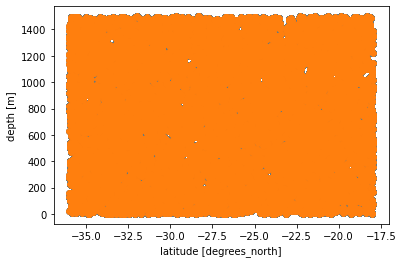

In [9]:
particle_ds.plot.scatter(x="lat", y="z")
particle_ds.isel(obs=0).plot.scatter(x="lat", y="z")

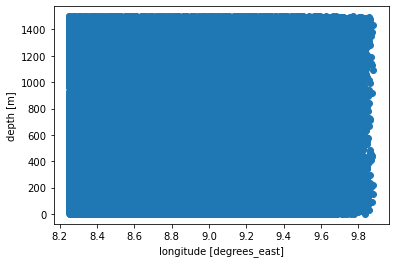

In [11]:
particle_ds.plot.scatter(x="lon", y="z")

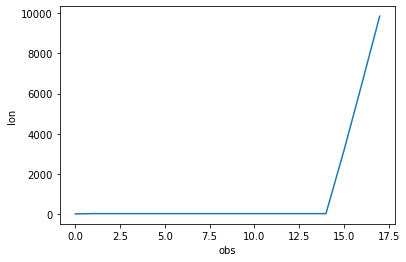

In [32]:
particle_ds.lon.isnull().sum("traj").plot()

##### 